In [1]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import cv2
import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import os
import random
import albumentations
import torch
from albumentations.pytorch import ToTensorV2
from model import MixStyleResCausalModel
import matplotlib.pyplot as plt

In [2]:
PRE__MEAN = [0.485, 0.456, 0.406]
PRE__STD = [0.229, 0.224, 0.225]
INPUT__FACE__SIZE = 256
THRESHOLD = .7
PADDING = 10

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    os.environ['PYTHONHASHSEED'] = str(seed)

def preprocess_frame_pipe():
    return albumentations.Compose([
        albumentations.Resize(height=INPUT__FACE__SIZE, width=INPUT__FACE__SIZE),
        albumentations.Normalize(PRE__MEAN, PRE__STD, always_apply=True),
        ToTensorV2(),    
    ])

def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = preprocess_frame_pipe()(image=frame)['image']
    frame = torch.tensor(frame).unsqueeze(0)
    return frame

In [4]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

set_seed(seed=777)

In [17]:
model_path = '../checkpoints/CAMR_S/best_model.pth'
num_classes = 5

In [18]:
model = torch.nn.DataParallel(MixStyleResCausalModel(model_name='resnet18',  pretrained=False, num_classes=num_classes, ms_layers=[]))
model = model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

target_layers = [model.module.feature_extractor.layer4[-1]]
targets = [ClassifierOutputTarget(num_classes-1)]

model.eval()

cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

No MixStyle


In [20]:
train_df = pd.read_csv('../Data/train/train_label.csv')
test_df = pd.read_csv('../Data/test/test_label.csv')
multrain_df = pd.read_csv('../Data/train/multiclass_cfpad_train.csv')
multest_df = pd.read_csv('../Data/test/multiclass_cfpad_test.csv')

/var/folders/pt/590dq6590r35jv003k31v8dc0000gn/T/ipykernel_13581/2998456027.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame = torch.tensor(frame).unsqueeze(0)


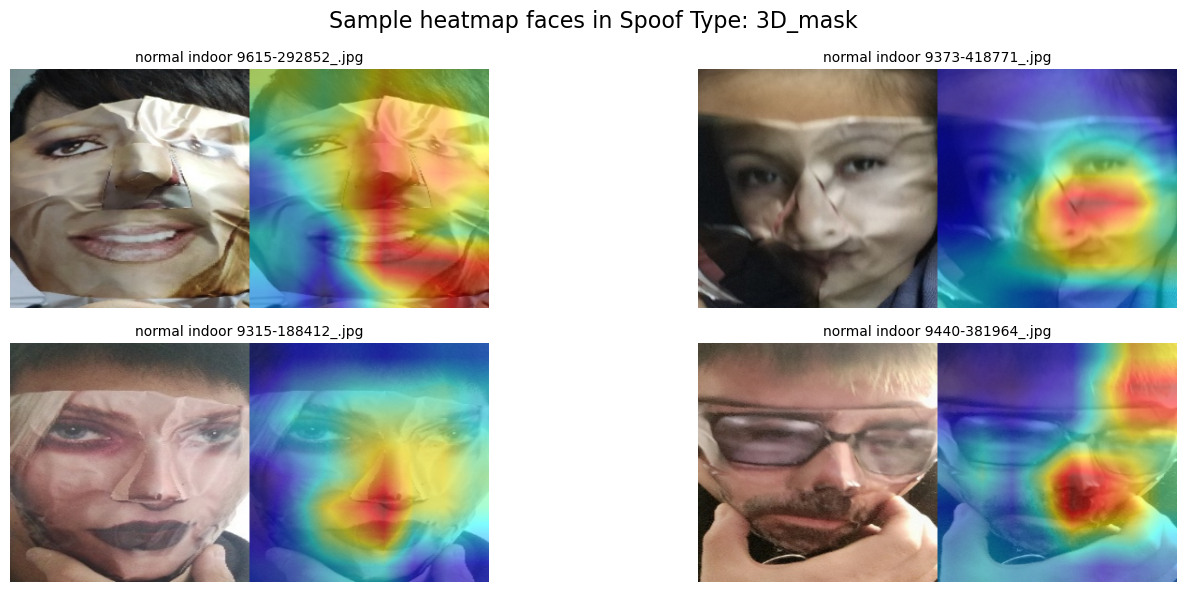

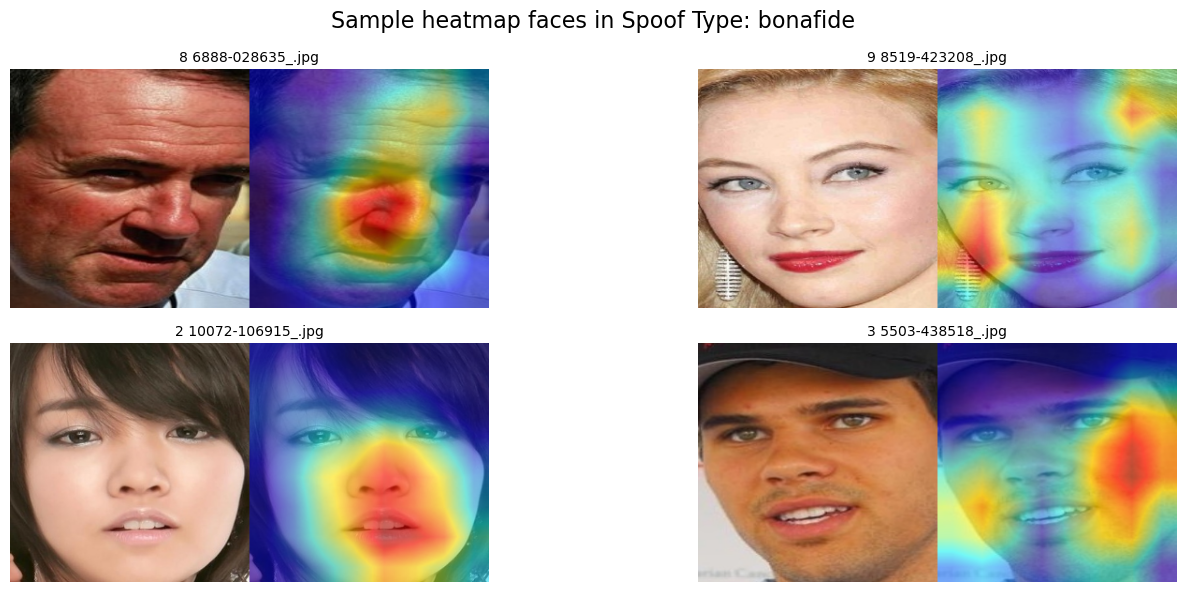

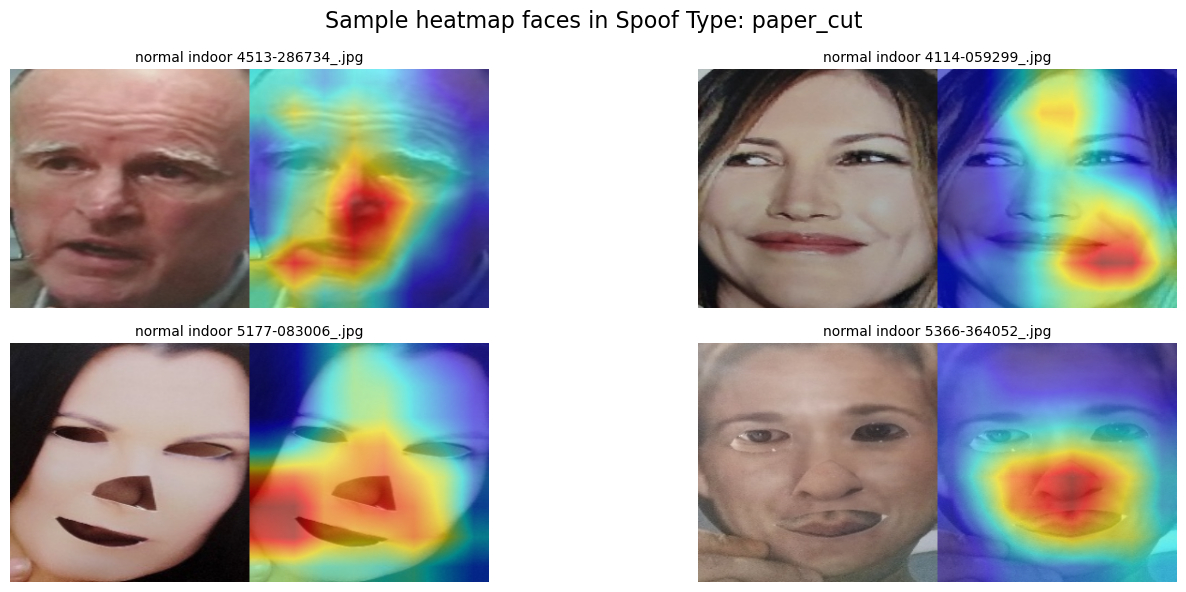

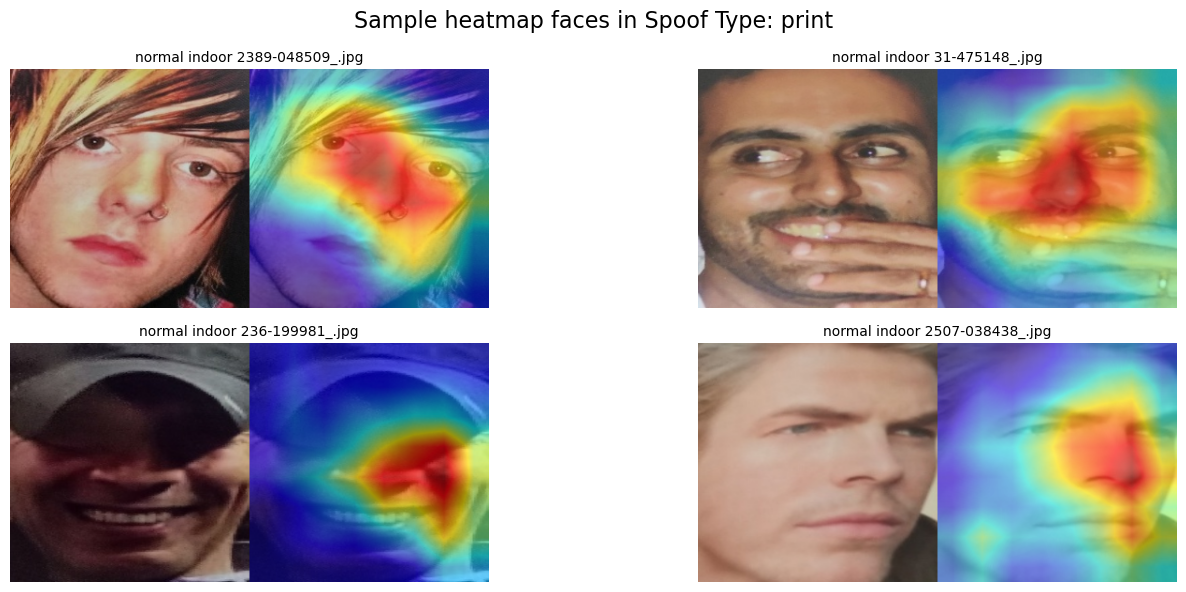

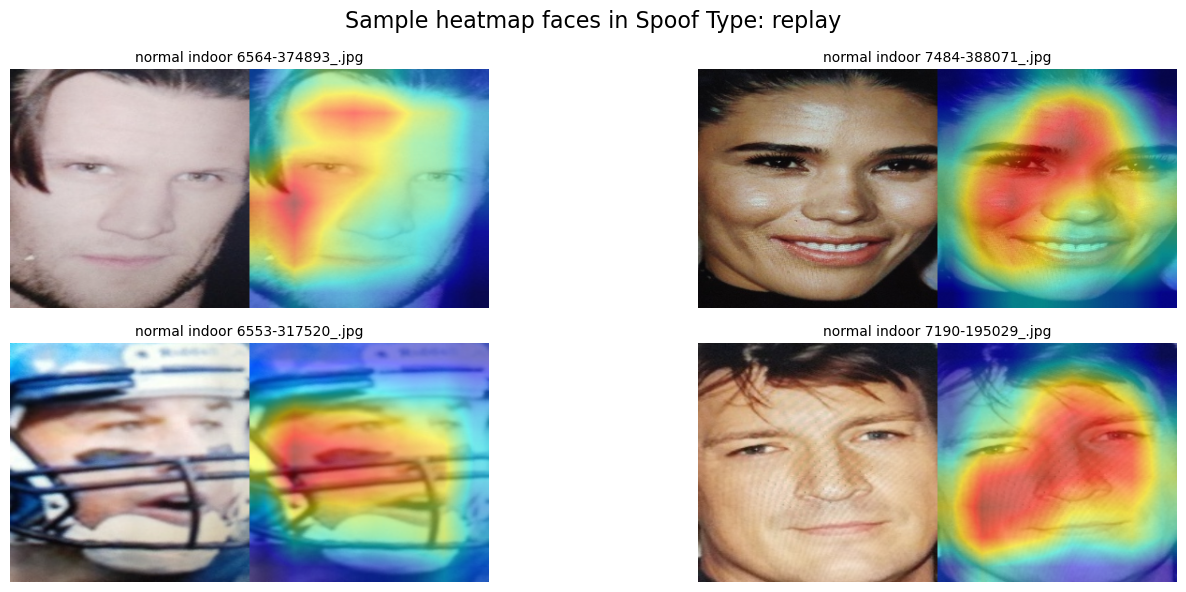

In [24]:
def display_face_heatmap(face, cam):
    input_frame = preprocess_frame(face).to(device)
    output = model(input_frame, cf=None)
    raw_scores = output.softmax(dim=1)[:, 1].cpu().data.numpy()[0]
    grayscale_cam = cam(input_tensor=input_frame, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image((np.float32(cv2.resize(face, (256, 256))) / 255) , grayscale_cam, use_rgb=False)
    return visualization, raw_scores > THRESHOLD

def display_images(images, spoof_type, title, x, y):
    fig, axes = plt.subplots(x, y, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axes.flatten()):
        if (i < len(images)):
            img = cv2.imread( '../' + images[i])
            viz, pred = display_face_heatmap(face=img, cam=cam)
            pos = pred == (spoof_type == 'live')
            if not pos:
                img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 255])
            combined_img = np.hstack((cv2.resize(img, (256, 256)), viz))
            ax.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
            ax.set_title((" ").join(images[i].split('/')[3:]), fontsize=10)
            ax.axis('off')
            ax.annotate(f'', xy=(0.5, -0.1), xycoords='axes fraction', ha='center', va='center', fontsize=5)
    plt.tight_layout()
    plt.show()

def visualize_samples(df, x, y):
    grouped = df.groupby(df.columns[1])
    for spoof_type, group in grouped:
        if len(group) > 0:
            image_len = len(group)
            sample_indices = group[df.columns[0]].sample(n=min(len(group), x*y), replace=False).index
            sample_images = group.loc[sample_indices, df.columns[0]].tolist()
            display_images(sample_images, spoof_type, f'Sample heatmap faces in Spoof Type: {spoof_type}', x, y)

visualize_samples(multrain_df, 2, 2)